**Copyright (c) 2025. Nicholas Kuo, UNSW**</br>
All rights reserved.

This file forms part of the *Health Gym* and is released under the terms of the</br>
MIT Licence Agreement.

The original implementations accompanied the publications:

> *The Health Gym: synthetic clinical data for the development of reinforcement learning algorithms for healthcare*
> *Scientific Data (Nature), 2022.*
> DOI: [10.1038/s41597-022-01784-7](https://doi.org/10.1038/s41597-022-01784-7)

> *Generating synthetic clinical data that capture class-imbalanced distributions with generative adversarial networks: Example using antiretroviral therapy for HIV*
> *Journal of Biomedical Informatics, 2023.*
> DOI: [10.1016/j.jbi.2023.104514](https://www.sciencedirect.com/science/article/pii/S1532046423001570)


In [ ]:
# ========================
# Standard Library
# ========================
import os
import random
import itertools
from copy import deepcopy
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

# ========================
# Core Scientific Stack
# ========================
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.special import boxcox as sp_boxcox

# ========================
# Machine Learning Utilities
# ========================
from sklearn.model_selection import train_test_split

# ========================
# Deep Learning (PyTorch)
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.utils.data import DataLoader, TensorDataset

# ========================
# Visualization
# ========================
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def seed_all(seed: int = 42, deterministic: bool = True) -> None:
    import os, random, numpy as np, torch

    # Python built-ins
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # cuDNN settings
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = not deterministic

    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False


In [ ]:
seed_all()

# === Categorical Mapping Utilities (simple & tidy) ===
BINCAT_STR2INT = {
    "Gender": {"Male": 0, "Female": 1},
    "Ethnic": {"Asian": 0, "African": 1, "Caucasian": 2, "Other": 3},
    "Base Drug Combo": {
        "FTC + TDF": 0, "3TC + ABC": 1, "FTC + TAF": 2,
        "DRV + FTC + TDF": 3, "FTC + RTVB + TDF": 4, "Other": 5
    },
    "Extra PI": {"DRV": 0, "RTVB": 1, "LPV": 2, "RTV": 3, "ATV": 4, "Not Applied": 5},
    "Extra pk-En": {"False": 0, "True": 1},   # ← fixed typo
}

BINCAT_INT2STR = {
    "Gender": {0: "Male", 1: "Female"},
    "Ethnic": {0: "Asian", 1: "African", 2: "Caucasian", 3: "Other"},
    "Base Drug Combo": {
        0: "FTC + TDF", 1: "3TC + ABC", 2: "FTC + TAF",
        3: "DRV + FTC + TDF", 4: "FTC + RTVB + TDF", 5: "Other"
    },
    "Extra PI": {0: "DRV", 1: "RTVB", 2: "LPV", 3: "RTV", 4: "ATV", 5: "Not Applied"},
    "Extra pk-En": {0: "False", 1: "True"},   # ← fixed typo
}

def BinCat2Num(df: pd.DataFrame, allow_already_int: bool = True) -> pd.DataFrame:
    """
    Map categorical string columns → integer codes (0..K-1).
    If allow_already_int=True, columns already coded as ints in the valid range are left as-is.
    """
    out = df.copy()
    for col, mapping in BINCAT_STR2INT.items():
        if col not in out.columns:
            continue
        s = out[col]
        if allow_already_int and pd.api.types.is_integer_dtype(s):
            # Validate codes are within allowed range
            allowed = set(mapping.values())
            bad = set(pd.Series(s.dropna().unique(), dtype=int)) - allowed
            if bad:
                raise ValueError(f"Unexpected integer codes in '{col}': {sorted(bad)}")
            continue
        mapped = s.map(mapping)
        if mapped.isnull().any():
            bad_vals = s[mapped.isnull()].unique()
            raise ValueError(f"Unmapped values in column '{col}': {bad_vals}")
        out[col] = mapped.astype(int)
    return out

def BinCat2Str(df: pd.DataFrame) -> pd.DataFrame:
    """Map categorical integer codes → string labels."""
    out = df.copy()
    for col, mapping in BINCAT_INT2STR.items():
        if col in out.columns:
            out[col] = out[col].map(mapping)
    return out


In [ ]:
seed_all()

# ========================
# Fit Box–Cox parameters
# ========================
def compute_boxcox_params(
    df: pd.DataFrame,
    columns: List[str] = ("VL", "CD4"),
    eps: float = 1e-3,
) -> Dict[str, dict]:
    """
    Fit Box–Cox λ per column on (x + eps), and store min/range of the
    transformed values for later [0,1] scaling.
    """
    params: Dict[str, dict] = {}
    for col in columns:
        x = df[col].dropna().astype(float).to_numpy()
        x = x + eps  # ensure positivity

        # Handle empty/degenerate columns safely
        if x.size == 0 or not np.all(np.isfinite(x)) or np.min(x) <= 0 or np.ptp(x) == 0:
            params[col] = {"lambda": 1.0, "min": 0.0, "range": 1.0, "eps": eps}
            continue

        bc, lam = stats.boxcox(x)  # returns transformed values + MLE λ
        bc_min = float(np.min(bc))
        bc_rng = float(np.max(bc) - bc_min) or 1.0  # avoid zero range

        params[col] = {"lambda": float(lam), "min": bc_min, "range": bc_rng, "eps": eps}
    return params


# ========================
# Box–Cox + Min–Max → [0,1]
# ========================
def apply_boxcox_minmax_transform(
    df: pd.DataFrame,
    params: Dict[str, dict],
    columns: List[str] = ("VL", "CD4"),
) -> pd.DataFrame:
    """
    Apply Box–Cox with fitted λ, then scale to [0,1] via stored min/range.
    NaNs are preserved.
    """
    out = df.copy()
    for col in columns:
        if col not in out.columns:
            continue
        p = params[col]
        mask = out[col].notna().to_numpy()
        if not mask.any():
            continue

        x = out.loc[mask, col].astype(float).to_numpy() + p["eps"]
        bc = sp_boxcox(x, p["lambda"])  # fixed-λ forward transform
        scaled = (bc - p["min"]) / p["range"]
        out.loc[mask, col] = scaled
    return out


# ========================
# Inverse Box–Cox (Torch)
# ========================
def inverse_boxcox_torch(bc: torch.Tensor, lmbda: float, eps: float = 1e-3) -> torch.Tensor:
    """
    Invert Box–Cox (on Box–Coxed values) to original x (minus eps shift).
    """
    if lmbda == 0.0:
        return torch.exp(bc) - eps
    base = torch.clamp(lmbda * bc + 1.0, min=1e-12)  # numeric safety
    return torch.pow(base, 1.0 / lmbda) - eps


# ========================
# Back-transform features
# ========================
def backtransform_art_tensor(
    tensor: torch.Tensor,
    feature_names: List[str],
    transform_params: Dict[str, dict],
    real_columns: List[str] = ("VL", "CD4"),
) -> pd.DataFrame:
    """
    Expects `tensor` with real cols in scaled Box–Cox space ([0,1]).
    Steps: unscale to Box–Cox → inverse Box–Cox → subtract eps.
    """
    x = tensor.detach().clone()
    idx_map = {n: i for i, n in enumerate(feature_names)}

    for col in real_columns:
        if col not in idx_map:
            continue
        i = idx_map[col]
        p = transform_params[col]
        bc = x[:, i] * p["range"] + p["min"]
        x[:, i] = inverse_boxcox_torch(bc, p["lambda"], p["eps"])

    return pd.DataFrame(x.cpu().numpy(), columns=feature_names)

In [ ]:
seed_all()

# === Load and Preprocess Raw Data ===
raw_url = "https://figshare.com/ndownloader/files/40584980"
DROP_COLS = ["VL (M)", "CD4 (M)", "Drug (M)"]

# 1) Read only the columns we need
_all_cols = pd.read_csv(raw_url, nrows=0).columns.tolist()
usecols = [c for c in _all_cols if c not in DROP_COLS]
All_Data = pd.read_csv(raw_url, usecols=usecols)

# 2) Map numeric codes -> human-readable labels (with typo fixed)
NUM2STR = {
    "Gender":          {1: "Male", 2: "Female"},
    "Ethnic":          {1: "Asian", 2: "African", 3: "Caucasian", 4: "Other"},
    "Base Drug Combo": {
        0: "FTC + TDF", 1: "3TC + ABC", 2: "FTC + TAF",
        3: "DRV + FTC + TDF", 4: "FTC + RTVB + TDF", 5: "Other"
    },
    "Comp. INI":       {0: "DTG", 1: "RAL", 2: "EVG", 3: "Not Applied"},
    "Comp. NNRTI":     {0: "NVP", 1: "EFV", 2: "RPV", 3: "Not Applied"},
    "Extra PI":        {0: "DRV", 1: "RTVB", 2: "LPV", 3: "RTV", 4: "ATV", 5: "Not Applied"},
    "Extra pk-En":     {0: "False", 1: "True"},   # <-- fixed typo
}

for col, mapping in NUM2STR.items():
    if col in All_Data.columns:
        mapped = All_Data[col].map(mapping)
        if mapped.isnull().any():
            bad = All_Data.loc[mapped.isnull(), col].unique()
            raise ValueError(f"Unmapped codes in '{col}': {bad}")
        All_Data[col] = mapped.astype("category")

for cont in ("VL", "CD4"):
    if cont in All_Data.columns:
        All_Data[cont] = pd.to_numeric(All_Data[cont], errors="coerce")


In [ ]:
seed_all()

# === Create smaller demo dataset for collaborators ===
SEL_COLS = [
    "VL", "CD4", "Gender", "Ethnic", "Base Drug Combo",
    "Extra PI", "Extra pk-En", "PatientID", "Timestep"
]

# Filter by PatientID, select only wanted columns, reset index
Sub_Data = (
    All_Data.loc[All_Data["PatientID"] < 300, SEL_COLS]
            .reset_index(drop=True)
)

missing = set(SEL_COLS) - set(All_Data.columns)
if missing:
    raise KeyError(f"Missing expected columns in All_Data: {missing}")


In [ ]:
seed_all()
# --- Canonical column names for downstream ---
REAL_COLS = ["VL", "CD4"]
CAT_SIZES = {
    "Gender": 2,
    "Ethnic": 4,
    "Base_Drug_Combo": 6,
    "Extra_PI": 6,
    "Extra_pk_En": 2,
}

# Embedding sizes policy
EMB_SIZE_FOR = {
    "real": lambda k: 1,     # passthrough
    "bin":  lambda k: 2,     # small embedding for binary
    "cat":  lambda k: 4,     # fixed 4-dim for multiclass
}

def build_dtype(real_cols, cat_sizes, emb_policy=EMB_SIZE_FOR, start_idx=0):
    rows = []
    idx = start_idx
    i = 0

    # Reals
    for name in real_cols:
        k = 1
        emb = emb_policy["real"](k)
        rows.append([i, name, "real", k, emb, idx, idx + k])
        idx += k; i += 1

    # Categorical (emit num_classes one-hot dims)
    for name, k in cat_sizes.items():
        ftype = "bin" if k == 2 else "cat"
        emb = emb_policy[ftype](k)
        rows.append([i, name, ftype, k, emb, idx, idx + k])
        idx += k; i += 1

    dtype = pd.DataFrame(rows, columns=[
        "index", "name", "type", "num_classes",
        "embedding_size", "index_start", "index_end"
    ])
    return dtype

def validate_dtype(dtype: pd.DataFrame, expected_total=None):
    d = dtype.sort_values("index").reset_index(drop=True)
    # contiguous spans
    starts = d["index_start"].to_numpy()
    ends   = d["index_end"].to_numpy()
    assert np.all(starts[1:] == ends[:-1]), "Spans must be contiguous"
    # monotonic & positive widths
    assert np.all(ends > starts), "Each span must have positive width"
    # total width
    total = int(ends[-1])
    if expected_total is not None:
        assert total == expected_total, f"Total dims {total} != expected {expected_total}"
    return total

def expand_feature_names(dtype: pd.DataFrame):
    names = []
    for _, r in dtype.iterrows():
        if r["type"] == "real":
            names.append(r["name"])
        else:
            k = int(r["num_classes"])
            names.extend([f"{r['name']}_{j}" for j in range(k)])
    return names

# ---- Building schema ----
dtype = build_dtype(REAL_COLS, CAT_SIZES)
TOTAL_DIM = validate_dtype(dtype)
FEATURE_NAMES = expand_feature_names(dtype)
assert len(FEATURE_NAMES) == TOTAL_DIM


In [ ]:
dtype

,index,name,type,num_classes,embedding_size,index_start,index_end
0,0,VL,real,1,1,0,1
1,1,CD4,real,1,1,1,2
2,2,Gender,bin,2,2,2,4
3,3,Ethnic,cat,4,4,4,8
4,4,Base_Drug_Combo,cat,6,4,8,14
5,5,Extra_PI,cat,6,4,14,20
6,6,Extra_pk_En,bin,2,2,20,22


In [ ]:
seed_all()

from typing import Tuple, Optional
def Execute_C003(
    df: pd.DataFrame,
    batch_size: int,
    cur_len: int = 10,
    drop_incomplete: bool = True,
    num_workers: int = 0,
    pin_memory: bool = False,
    generator: Optional[torch.Generator] = None,
) -> Tuple[DataLoader, torch.Tensor]:
    x_np = df.to_numpy(dtype=np.float32, copy=False)
    n_rows, feats_len = x_np.shape

    if n_rows < cur_len:
        raise ValueError(f"Not enough rows ({n_rows}) for a sequence of length {cur_len}.")

    remainder = n_rows % cur_len
    if remainder != 0:
        if drop_incomplete:
            n_rows = n_rows - remainder
            x_np = x_np[:n_rows]
        else:
            raise ValueError(f"{n_rows} rows not divisible by cur_len={cur_len}.")

    n_seq = n_rows // cur_len
    x_np = x_np.reshape(n_seq, cur_len, feats_len)

    x_t = torch.from_numpy(x_np)  # [n_seq, cur_len, feats]
    lengths = torch.full((n_seq,), cur_len, dtype=torch.long)
    dataset = TensorDataset(x_t, lengths)

    trn_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        generator=generator,
    )

    all_batches = [xb for xb, _ in trn_loader]
    all_trainable = torch.cat(all_batches, dim=0)

    return trn_loader, all_trainable


In [ ]:
seed_all()

# 1) Map categoricals to ints using your simple mapper (expects spaced names)
Sub_Data = BinCat2Num(Sub_Data)

# 2) Rename once so columns match your dtype/schema (snake_case)
NAME_MAP = {
    "Base Drug Combo": "Base_Drug_Combo",
    "Extra PI":        "Extra_PI",
    "Extra pk-En":     "Extra_pk_En",
}
Sub_Data = Sub_Data.rename(columns=NAME_MAP)

# 3) Fit Box–Cox params on real columns
REAL_COLS = [r["name"] for _, r in dtype.query("type == 'real'").iterrows()]
art_transformation_params = compute_boxcox_params(Sub_Data, columns=REAL_COLS)

# 4) Helpers to expand dtype → feature names (reals + one-hot blocks)
def expand_feature_names_from_dtype(dtype_df: pd.DataFrame):
    names = []
    for _, r in dtype_df.iterrows():
        if r["type"] == "real":
            names.append(r["name"])
        else:
            names += [f"{r['name']}_{j}" for j in range(int(r["num_classes"]))]
    return names

FEATURE_NAMES = expand_feature_names_from_dtype(dtype)

def design_from_dtype(df: pd.DataFrame, dtype_df: pd.DataFrame, params: dict) -> pd.DataFrame:
    real_cols = [r["name"] for _, r in dtype_df.query("type == 'real'").iterrows()]
    cat_blocks = [(r["name"], int(r["num_classes"])) for _, r in dtype_df.query("type != 'real'").iterrows()]

    # sanity: required columns
    required = set(real_cols + [n for n, _ in cat_blocks])
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns for design matrix: {sorted(missing)}")

    # Reals → Box–Cox + [0,1]
    X_real = apply_boxcox_minmax_transform(df[real_cols].copy(), params, columns=real_cols)

    # Categoricals → stable one-hot (0..K-1)
    X_cat_parts = []
    for name, k in cat_blocks:
        s = df[name].astype("Int64")
        s = pd.Categorical(s, categories=list(range(k)))
        dmy = pd.get_dummies(s, prefix=name, prefix_sep="_", dtype=np.int8)
        needed = [f"{name}_{j}" for j in range(k)]
        for c in needed:
            if c not in dmy.columns:
                dmy[c] = 0
        X_cat_parts.append(dmy[needed])

    X_cat = pd.concat(X_cat_parts, axis=1) if X_cat_parts else pd.DataFrame(index=df.index)
    X = pd.concat([X_real, X_cat], axis=1).reindex(columns=FEATURE_NAMES, fill_value=0)
    return X

# 5) Build curriculum loaders
CURRICULUM_LENGTHS = [10, 20, 30, 40, 50, 60]
BATCH_SIZE = 256

def slice_by_len(df: pd.DataFrame, L: int) -> pd.DataFrame:
    if "Timestep" not in df.columns:
        raise KeyError("Expected 'Timestep' column in input dataframe.")
    return df.loc[df["Timestep"] < L].reset_index(drop=True)

g = torch.Generator().manual_seed(42)  # reproducible shuffles

only10_60 = {}
for L in CURRICULUM_LENGTHS:
    dfL = slice_by_len(Sub_Data, L)
    XL = design_from_dtype(dfL, dtype, art_transformation_params)
    loader_L, _ = Execute_C003(XL, batch_size=BATCH_SIZE, cur_len=L, drop_incomplete=True, generator=g)
    only10_60[L] = loader_L

# 6) Pool for correlation/eval with longest length
X_all = design_from_dtype(Sub_Data, dtype, art_transformation_params)
_, All_Trainable_Data = Execute_C003(X_all, batch_size=BATCH_SIZE, cur_len=60, drop_incomplete=True, generator=g)


In [ ]:
seed_all()

def correlation(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:

    # Flatten samples, keep features
    f = x.shape[-1]
    x = x.reshape(-1, f).to(dtype=torch.float32)

    n = x.shape[0]
    if n < 2:
        return torch.eye(f, dtype=x.dtype, device=x.device)

    # Center
    x = x - x.mean(dim=0, keepdim=True)

    # Standardize with sample std (unbiased=True)
    std = x.std(dim=0, unbiased=True)
    # Avoid div-by-zero for constant columns
    std = torch.where(std < eps, torch.ones_like(std), std)
    x = x / std

    # Pearson correlation = (X^T X) / (n - 1)
    corr = (x.transpose(0, 1) @ x) / (n - 1)

    # Clamp tiny numerical drift, enforce diag = 1
    corr = corr.clamp(min=-1.0, max=1.0)
    corr.fill_diagonal_(1.0)
    return corr

correlation_real = correlation(All_Trainable_Data)


In [ ]:
seed_all()

class MyLSTM(nn.Module):
    def __init__(self, ID, HD):
        super().__init__()
        self.ID = ID
        self.HD = HD
        self.i2h = nn.Linear(ID, HD * 4)
        self.h2h = nn.Linear(HD, HD * 4)

    def forward(self, x0):
        Q_k = torch.zeros(x0.shape[0], self.HD, device=x0.device)
        S_k = torch.zeros(x0.shape[0], self.HD, device=x0.device)
        Q_all = []
        for t in range(x0.shape[1]):
            X_k = x0[:, t, :]
            F_i, I_i, A_i, O_i = self.i2h(X_k).chunk(4, dim=1)
            F_h, I_h, A_h, O_h = self.h2h(Q_k).chunk(4, dim=1)
            F_k = torch.sigmoid(F_i + F_h)
            I_k = torch.sigmoid(I_i + I_h)
            A_k = torch.tanh(A_i + A_h)
            O_k = torch.sigmoid(O_i + O_h)
            S_k = F_k * S_k + I_k * A_k
            Q_k = O_k * torch.tanh(S_k)
            Q_all.append(Q_k.unsqueeze(1))
        Q_all = torch.cat(Q_all, dim=1)
        return Q_all, (Q_k, S_k)


class Generator(nn.Module):
    def __init__(self, Hyper006_ID, Hyper007_HD, data_types):
        super().__init__()
        ID, HD = Hyper006_ID, Hyper007_HD
        self.rnn_f = MyLSTM(ID, HD)
        self.rnn_r = MyLSTM(ID, HD)
        self.linear1 = nn.Linear(2 * HD, HD)
        self.linear2 = nn.Linear(HD, HD)
        self.linear3 = nn.Linear(HD, max(data_types["index_end"]))
        self.leakyReLU = nn.LeakyReLU(0.1)
        self.output_activations = []
        max_real = max(data_types.loc[data_types["type"] == "real", "index_end"])
        self.output_activations.append(lambda x: torch.sigmoid(x[..., 0:max_real]))
        for _, row in data_types.iterrows():
            if row["type"] != "real":
                idxs, idxe = row["index_start"], row["index_end"]
                self.output_activations.append(
                    lambda x, idxs=idxs, idxe=idxe: torch.softmax(x[..., idxs:idxe], dim=-1)
                )

    def forward(self, x0):
        x1_f, _ = self.rnn_f(x0)
        x1_r, _ = self.rnn_r(x0.flip(dims=[1]))
        x1 = torch.cat((x1_f, x1_r), dim=2)
        x2 = self.leakyReLU(self.linear1(x1))
        x3 = self.leakyReLU(self.linear2(x2))
        x4 = self.linear3(x3)
        x_list = [f(x4) for f in self.output_activations]
        return torch.cat(x_list, dim=-1)


class Discriminator(nn.Module):
    def __init__(self, Hyper007_HD, data_types):
        super().__init__()
        HD, OD = Hyper007_HD, 1
        self.max_real = max(data_types.loc[data_types["type"] == "real", "index_end"])
        self.embedding_layers = nn.ModuleList()
        self.soft_embedding = []
        for _, row in data_types.iterrows():
            if row["type"] != "real":
                self.embedding_layers.append(nn.Embedding(row["num_classes"], row["embedding_size"]))
                idxs, idxe = row["index_start"], row["index_end"]
                self.soft_embedding.append(
                    lambda x, W, idxs=idxs, idxe=idxe: x[..., idxs:idxe] @ W
                )
        self.linear1 = nn.Linear(sum(data_types["embedding_size"]), HD)
        self.linear2 = nn.Linear(HD, HD)
        self.rnn_f = MyLSTM(HD, HD)
        self.rnn_r = MyLSTM(HD, HD)
        self.linear3 = nn.Linear(2 * HD, OD)
        self.leakyReLU = nn.LeakyReLU(0.1)

    def forward(self, x0):
        x_list = [x0[..., :self.max_real]] + [
            f(x0, emb.weight) for f, emb in zip(self.soft_embedding, self.embedding_layers)
        ]
        x1 = torch.cat(x_list, dim=-1)
        x2 = self.leakyReLU(self.linear1(x1))
        x3 = self.leakyReLU(self.linear2(x2))
        _, (x4_f, _) = self.rnn_f(x3)
        _, (x4_r, _) = self.rnn_r(x3.flip(dims=[1]))
        x4 = torch.cat((x4_f, x4_r), dim=1)
        return self.linear3(x4)

###===>>> New stuff here for V2 <<<===###
class MyAE(nn.Module):

    ###===###
    def __init__(self,
                 Hyper007_HD,
                 data_types):
        super().__init__()

        ###===###
        ID = sum(data_types["embedding_size"])
        HD = Hyper007_HD
        OD = sum(data_types["embedding_size"])

        ####===###
        self.L1 = nn.Linear(ID, HD)
        self.S1 = nn.Linear(ID, HD)
        self.L2 = nn.Linear(HD, HD)
        self.L3 = nn.Linear(HD, HD)

        self.Encoder = nn.Linear(HD, HD)
        self.Decoder = nn.Linear(HD, OD)

        #---
        self.data_types = data_types

        #---
        self.d_slot = 10000
        self.Mean_Container = torch.zeros(1, 1, HD).cuda()

    def forward(self, x0, self_D):

        ###===###
        x_list = [x0[..., 0 : self_D.max_real]] + [
            f(x0, embedding_layer.weight)
            for f, embedding_layer in zip(self_D.soft_embedding, self_D.embedding_layers)
        ]
        x1 = torch.cat(x_list, dim=-1)

        ###===###
        x2 = torch.relu(self.L1(x1) + self.S1(x1))
        x3 = torch.relu(self.L2(x2) + x2)
        x4 = torch.relu(self.L3(x3) + x3)

        ###===###
        Transformed = self.Encoder(x4)

        y_hat       = self.Decoder(Transformed)

        ###===###
        # add kld loss on Transformed
        T_var = Transformed.view(-1, Transformed.shape[2]).var(dim = 0)
        T_logvar = torch.log(T_var)

        T_mu  = Transformed.view(-1, Transformed.shape[2]).mean(dim = 0)

        kld_loss = -0.5 * (1 + T_logvar - T_mu ** 2 - T_var)
        kld_loss = torch.sum(kld_loss)

        ###===###
        AE_loss = F.mse_loss(y_hat, x1) + kld_loss

        #---
        Cur_feature = Transformed.view(-1, Transformed.shape[2])
        T_SD = Cur_feature.std(dim = 0).unsqueeze(0).unsqueeze(0).detach().data

        if self.Mean_Container.shape[0] == 1:
            Mean_Container = Transformed.mean(dim = 1).\
                                 unsqueeze(1).detach().data
        else:
            CF =             Transformed.mean(dim = 1).\
                                 unsqueeze(1).detach().data
            Mean_Container = torch.cat([self.Mean_Container, CF], dim = 0)

        if Mean_Container.shape[0] > self.d_slot:
            Cur_select = np.random.randint(
                            0, Mean_Container.shape[0], self.d_slot)
            Mean_Container = Mean_Container[Cur_select, :, :]

        self.Mean_Container = Mean_Container

        return AE_loss, T_SD


In [ ]:
seed_all()

def LoadPreTrain(content=[False,
                          'G_SD', 'D_SD',
                          ['A_SD', "A_MC"],
                          0]):
    if content[0]:
        G_SD = torch.load(content[1])
        D_SD = torch.load(content[2])
        A_SD = torch.load(content[3][0])
        A_MC = torch.load(content[3][1])

        return G_SD, D_SD, [A_SD, A_MC]

    else:
        return 0, 0, [0, 0]


class Execute_D004:
    def __init__(self,
                 Hyper001_BatchSize, Hyper002_Epochs,
                 Hyper003_G_iter, Hyper004_GP_Lambda, Hyper005_C_Lambda,
                 Hyper006_ID, Hyper007_HD,
                 Hyper008_LR, Hyper009_Betas,
                 data_types,
                 correlation_real,
                 continue_info=[False, 'G_SD', 'D_SD', 'A_SD', 0]): #<<<=== New stuff here for V2 <<<===###
        super().__init__()
        self.batch_size = Hyper001_BatchSize
        self.epochs = Hyper002_Epochs
        self.G_iter = Hyper003_G_iter
        self.gp_weight = Hyper004_GP_Lambda
        self.c_weight = Hyper005_C_Lambda
        self.ID = Hyper006_ID
        self.HD = Hyper007_HD
        self.lr = Hyper008_LR
        self.betas = Hyper009_Betas
        self.correlation_real = correlation_real.cuda()
        self.CUDA = torch.cuda.is_available()
        self.G = Generator(Hyper006_ID, Hyper007_HD, data_types)
        self.D = Discriminator(Hyper007_HD, data_types)
        if self.CUDA:
            self.G = self.G.cuda()
            self.D = self.D.cuda()
        G_SD, D_SD, _ = LoadPreTrain(continue_info)
        if G_SD != 0:
            self.G.load_state_dict(G_SD)
            self.D.load_state_dict(D_SD)
            self.PreviousEpoch = continue_info[4]
        else:
            self.PreviousEpoch = 0
        self.D_opt = optim.Adam(self.D.parameters(), lr=self.lr, betas=self.betas)
        self.G_opt = optim.Adam(self.G.parameters(), lr=self.lr, betas=self.betas)

        ###===>>> New stuff here for V2 <<<===###
        self.A = MyAE(
                    Hyper007_HD,
                    data_types)
        if self.CUDA:
          self.A = self.A.cuda()
          self.T_SD   = torch.ones( 1, 1, Hyper007_HD).cuda()
        _, _, [A_SD, A_MC] = LoadPreTrain(continue_info)
        if A_SD != 0:
            self.A.load_state_dict(A_SD)
            self.A.Mean_Container = A_MC
        self.A_opt = optim.Adam(self.A.parameters(), lr = self.lr, betas = self.betas)

    ###===###
    def generate_data(self, seq_len, num_samples = None):

        if num_samples is None:
            num_samples = self.batch_size

        #---
        z = torch.rand((num_samples, seq_len, self.ID)).cuda()

        ###===>>> New stuff here for V2 <<<===###
        Cur_select = np.random.randint(
                        0, self.A.Mean_Container.shape[0], num_samples)
        self_T_M = self.A.Mean_Container[Cur_select, :, :]

        z = z * self.T_SD + self_T_M

        ###===###
        data_fake = self.G(z)

        return data_fake

    ###===>>> New stuff here for V2 <<<===###
    def _AE_train(self, data_real):
        ###===###
        data_real = data_real
        AE_loss, T_SD = self.A(data_real, self.D)

        #---
        self.A_opt.zero_grad()
        AE_loss.backward()
        self.A_opt.step()

        ###===###
        self.T_SD   = (self.T_SD    + T_SD)     / 2

        return AE_loss.item()

    def _critic_train_iteration(self, data_real):
        data_fake = self.generate_data(data_real.shape[1], data_real.shape[0])
        D_real = self.D(data_real)
        D_fake = self.D(data_fake)
        with torch.backends.cudnn.flags(enabled=False):
            gradient_penalty = self._gradient_penalty(data_real, data_fake)
        self.D_opt.zero_grad()
        D_loss = D_fake.mean() - D_real.mean() + gradient_penalty
        D_loss.backward()
        self.D_opt.step()
        return D_loss.item(), gradient_penalty.item(), D_real.mean().item(), D_fake.mean().item()

    def _generator_train_iteration(self, seq_len):
        data_fake = self.generate_data(seq_len)
        D_fake = self.D(data_fake)
        corr_loss = self._correlation_loss(data_fake)
        self.G_opt.zero_grad()
        G_loss = -D_fake.mean() + self.c_weight * corr_loss
        G_loss.backward()
        self.G_opt.step()
        return G_loss.item(), corr_loss.item()

    def _correlation_loss(self, data_fake):
        correlation_fake = correlation(data_fake)
        criterion = nn.L1Loss(reduction="mean")
        temp = torch.rand_like(correlation_fake)
        temp_fake = torch.min(temp, torch.abs(correlation_fake))
        temp_real = torch.min(temp, torch.abs(self.correlation_real))
        correlation_fake = temp_fake * torch.sign(correlation_fake)
        correlation_real = temp_real * torch.sign(self.correlation_real)
        return criterion(correlation_fake, correlation_real)

    def _gradient_penalty(self, data_real, data_fake):
        alpha = torch.rand((self.batch_size, 1, 1)).cuda().expand_as(data_real)
        interpolated = alpha * data_real + (1 - alpha) * data_fake
        prob_interpolated = self.D(interpolated)
        gradients = autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(prob_interpolated).cuda(),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradients = gradients.view(self.batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def train(self, All_loader):
        All_Length = sorted(All_loader.keys())
        for epoch in range(self.epochs - self.PreviousEpoch):
            for Cur_Len in All_Length:
                Cur_loader = All_loader[Cur_Len]
                for batch_idx, (data_real, _) in enumerate(Cur_loader):
                    data_real = data_real.cuda()

                    ###===>>> New stuff here for V2 <<<===###
                    AE_loss = self._AE_train(data_real)

                    for _ in range(self.G_iter):
                        D_Loss, GP, D_real_mean, D_fake_mean = self._critic_train_iteration(data_real)
                    G_Loss, Corr_Loss = self._generator_train_iteration(seq_len=Cur_Len)
                    if (np.mod(batch_idx + 1, round(len(Cur_loader) / 5)) == 0) or \
                       (batch_idx + 1 == len(Cur_loader)):
                        print("#---")
                        print(f"[Epoch {self.PreviousEpoch + epoch + 1}] "
                              f"L={Cur_Len} step {batch_idx + 1}/{len(Cur_loader)} | "
                              f"D_loss={D_Loss:.4f} GP={GP:.4f} "
                              f"D_real={D_real_mean:.4f} D_fake={D_fake_mean:.4f} | "
                              f"G_loss={G_Loss:.4f} Corr={Corr_Loss:.4f}")

                        ###===>>> New stuff here for V2 <<<===###
                        print("A_Loss: \t{}".format(AE_loss))


In [ ]:
seed_all()

# ========================
# Experimental setup
# ========================
Hyper001_BatchSize = 256
Hyper002_Epochs    = 100

# ========================
# Training setup
# ========================
Hyper003_G_iter    = 5
Hyper004_GP_Lambda = 10
Hyper005_C_Lambda  = 10

# ========================
# Network setup
# ========================
Hyper006_ID        = 128
Hyper007_HD        = 128

# ========================
# Optimisation setup
# ========================
Hyper008_LR        = 1e-3
Hyper009_Betas     = (0.9, 0.99)

# ========================
# Pre-training continuation
# ========================
Hyper010_Continue  = False
Hyper011_G_SD      = "YDZ002_G_StateDict_Epoch0"
Hyper012_D_SD      = "YDZ002_D_StateDict_Epoch0"
Hyper0012_A_SD     = 'ZY002_A_StateDict_Epoch0'
Hyper0012_A_MC     = 'ZY002_Mean_Container_Epoch0'
Hyper013_PreEpoch  = 0


In [ ]:
wgan_gp = Execute_D004(
                Hyper001_BatchSize, Hyper002_Epochs,
                Hyper003_G_iter, Hyper004_GP_Lambda, Hyper005_C_Lambda,
                Hyper006_ID, Hyper007_HD,
                Hyper008_LR, Hyper009_Betas,
                dtype,
                correlation_real,
                [Hyper010_Continue,
                 Hyper011_G_SD, Hyper012_D_SD,
                 [Hyper0012_A_SD, Hyper0012_A_MC],
                 Hyper013_PreEpoch])


In [ ]:
wgan_gp.train(only10_60)

/tmp/ipython-input-1314674709.py:166: RuntimeWarning: divide by zero encountered in remainder
  if (np.mod(batch_idx + 1, round(len(Cur_loader) / 5)) == 0) or \


#---
[Epoch 1] L=10 step 1/1 | D_loss=6.7740 GP=6.9885 D_real=0.1730 D_fake=-0.0414 | G_loss=2.1069 Corr=0.2025
A_Loss: 	218.3963165283203
#---
[Epoch 1] L=20 step 1/1 | D_loss=-0.1228 GP=1.1591 D_real=0.8141 D_fake=-0.4678 | G_loss=3.4294 Corr=0.2747
A_Loss: 	189.70272827148438
#---
[Epoch 1] L=30 step 1/1 | D_loss=-0.5353 GP=3.0821 D_real=2.2154 D_fake=-1.4020 | G_loss=4.4452 Corr=0.3167
A_Loss: 	167.267578125
#---
[Epoch 1] L=40 step 1/1 | D_loss=-2.2775 GP=0.1360 D_real=1.6392 D_fake=-0.7743 | G_loss=3.9749 Corr=0.3292
A_Loss: 	143.7325439453125
#---
[Epoch 1] L=50 step 1/1 | D_loss=-2.4774 GP=0.2956 D_real=2.2921 D_fake=-0.4809 | G_loss=3.8178 Corr=0.3350
A_Loss: 	126.24855041503906
#---
[Epoch 1] L=60 step 1/1 | D_loss=-3.0595 GP=0.2789 D_real=2.7762 D_fake=-0.5622 | G_loss=3.6870 Corr=0.3071
A_Loss: 	109.27088928222656
#---
[Epoch 2] L=10 step 1/1 | D_loss=-2.6338 GP=0.3624 D_real=2.4607 D_fake=-0.5355 | G_loss=3.3115 Corr=0.2817
A_Loss: 	89.33908081054688
#---
[Epoch 2] L=20 st

In [ ]:
seed_all()

def _inv_boxcox_torch(y: torch.Tensor, lmbda: float, eps: float = 1e-3) -> torch.Tensor:
    if lmbda == 0:
        return torch.exp(y) - eps
    return torch.pow(lmbda * y + 1.0, 1.0 / lmbda) - eps

@torch.no_grad()
def Execute_C007(
    Data: torch.Tensor,
    dtype_schema,
    transform_params: dict,
    real_columns=("VL", "CD4"),
    eps: float = 1e-3,
) -> torch.Tensor:
    device = Data.device
    out_cols = []
    name_to_row = {row["name"]: row for _, row in dtype_schema.iterrows()}

    for name in dtype_schema["name"]:
        row = name_to_row[name]
        s, e, ftype = int(row["index_start"]), int(row["index_end"]), row["type"]
        if ftype == "real":
            y = Data[:, s]
            if name in real_columns:
                p = transform_params[name]
                bc = y * torch.as_tensor(p["range"], device=device) + torch.as_tensor(p["min"], device=device)
                x = _inv_boxcox_torch(bc, float(p["lambda"]), eps=float(p.get("eps", eps)))
            else:
                x = y
            out_cols.append(x.view(-1, 1).to(device=device, dtype=torch.float32))

    for name in dtype_schema["name"]:
        row = name_to_row[name]
        s, e, ftype = int(row["index_start"]), int(row["index_end"]), row["type"]
        if ftype in ("cat", "bin"):
            block = Data[:, s:e]
            idx = torch.argmax(block, dim=1).view(-1, 1)
            out_cols.append(idx.to(device=device, dtype=torch.float32))

    return torch.cat(out_cols, dim=1)


In [ ]:
seed_all()

def Execute_C008(data_types=None):
    Replace_Names = [
        "VL [copies/mL]",
        "CD4 [cells/μL]",
        "Gender",
        "Ethnic",
        "Base Drug Combo",
        "Extra PI",
        "Extra pk-En",
    ]
    Replace_Names2 = [
        "VL",
        "CD4",
        "Gender",
        "Ethnic",
        "Base Drug Combo",
        "Extra PI",
        "Extra pk-En",
    ]
    return Replace_Names, Replace_Names2


In [ ]:
seed_all()

sns.set_context("talk")
plt.rcParams.update({"font.size": 35, "legend.loc": "upper right"})

CATEGORY_LABELS = {
    "Gender": ["Male", "Female"],
    "Ethnic": ["Asian", "African", "Caucasian", "Other"],
    "Base Drug Combo": ["FTC + TDF", "3TC + ABC", "FTC + TAF",
                        "DRV + FTC + TDF", "FTC + RTVB + TDF", "Other"],
    "Extra PI": ["DRV", "RTVB", "LPV", "RTV", "ATV", "Not Applied"],
    "Extra pk-En": ["False", "True"],
}
REAL_NAMES = ["VL [copies/mL]", "CD4 [cells/μL]"]

def set_categorical_with_order(df: pd.DataFrame, col: str, ordered_labels):
    ctype = CategoricalDtype(categories=list(ordered_labels), ordered=True)
    df[col] = df[col].astype(str).astype(ctype)

def collect_loader_sequences(loader):
    xs = []
    for x, _ in loader:
        xs.append(x)
    return torch.cat(xs, dim=0)

def sample_and_flatten(seq_tensor: torch.Tensor, seq_len: int, max_rows: int = 10_000):
    n_seqs = seq_tensor.size(0)
    max_seqs = max(1, min(n_seqs, max_rows // seq_len))
    idx = torch.randperm(n_seqs)[:max_seqs]
    seqs = seq_tensor[idx]
    return seqs.reshape(-1, seq_tensor.size(-1))

def to_cpu(x: torch.Tensor):
    return x.detach().cpu()

def make_df(colname: str, real_col: np.ndarray, fake_col: np.ndarray, categorical=False):
    if categorical:
        df = pd.concat([
            pd.DataFrame({colname: fake_col.astype(int), "Type": "Synthetic"}),
            pd.DataFrame({colname: real_col.astype(int), "Type": "Real"}),
        ], ignore_index=True)
        labels = CATEGORY_LABELS.get(colname)
        if labels:
            df[colname] = df[colname].map(dict(enumerate(labels)))
            set_categorical_with_order(df, colname, labels)
        return df
    else:
        return pd.concat([
            pd.DataFrame({colname: fake_col.astype(float), "Type": "Synthetic"}),
            pd.DataFrame({colname: real_col.astype(float), "Type": "Real"}),
        ], ignore_index=True)


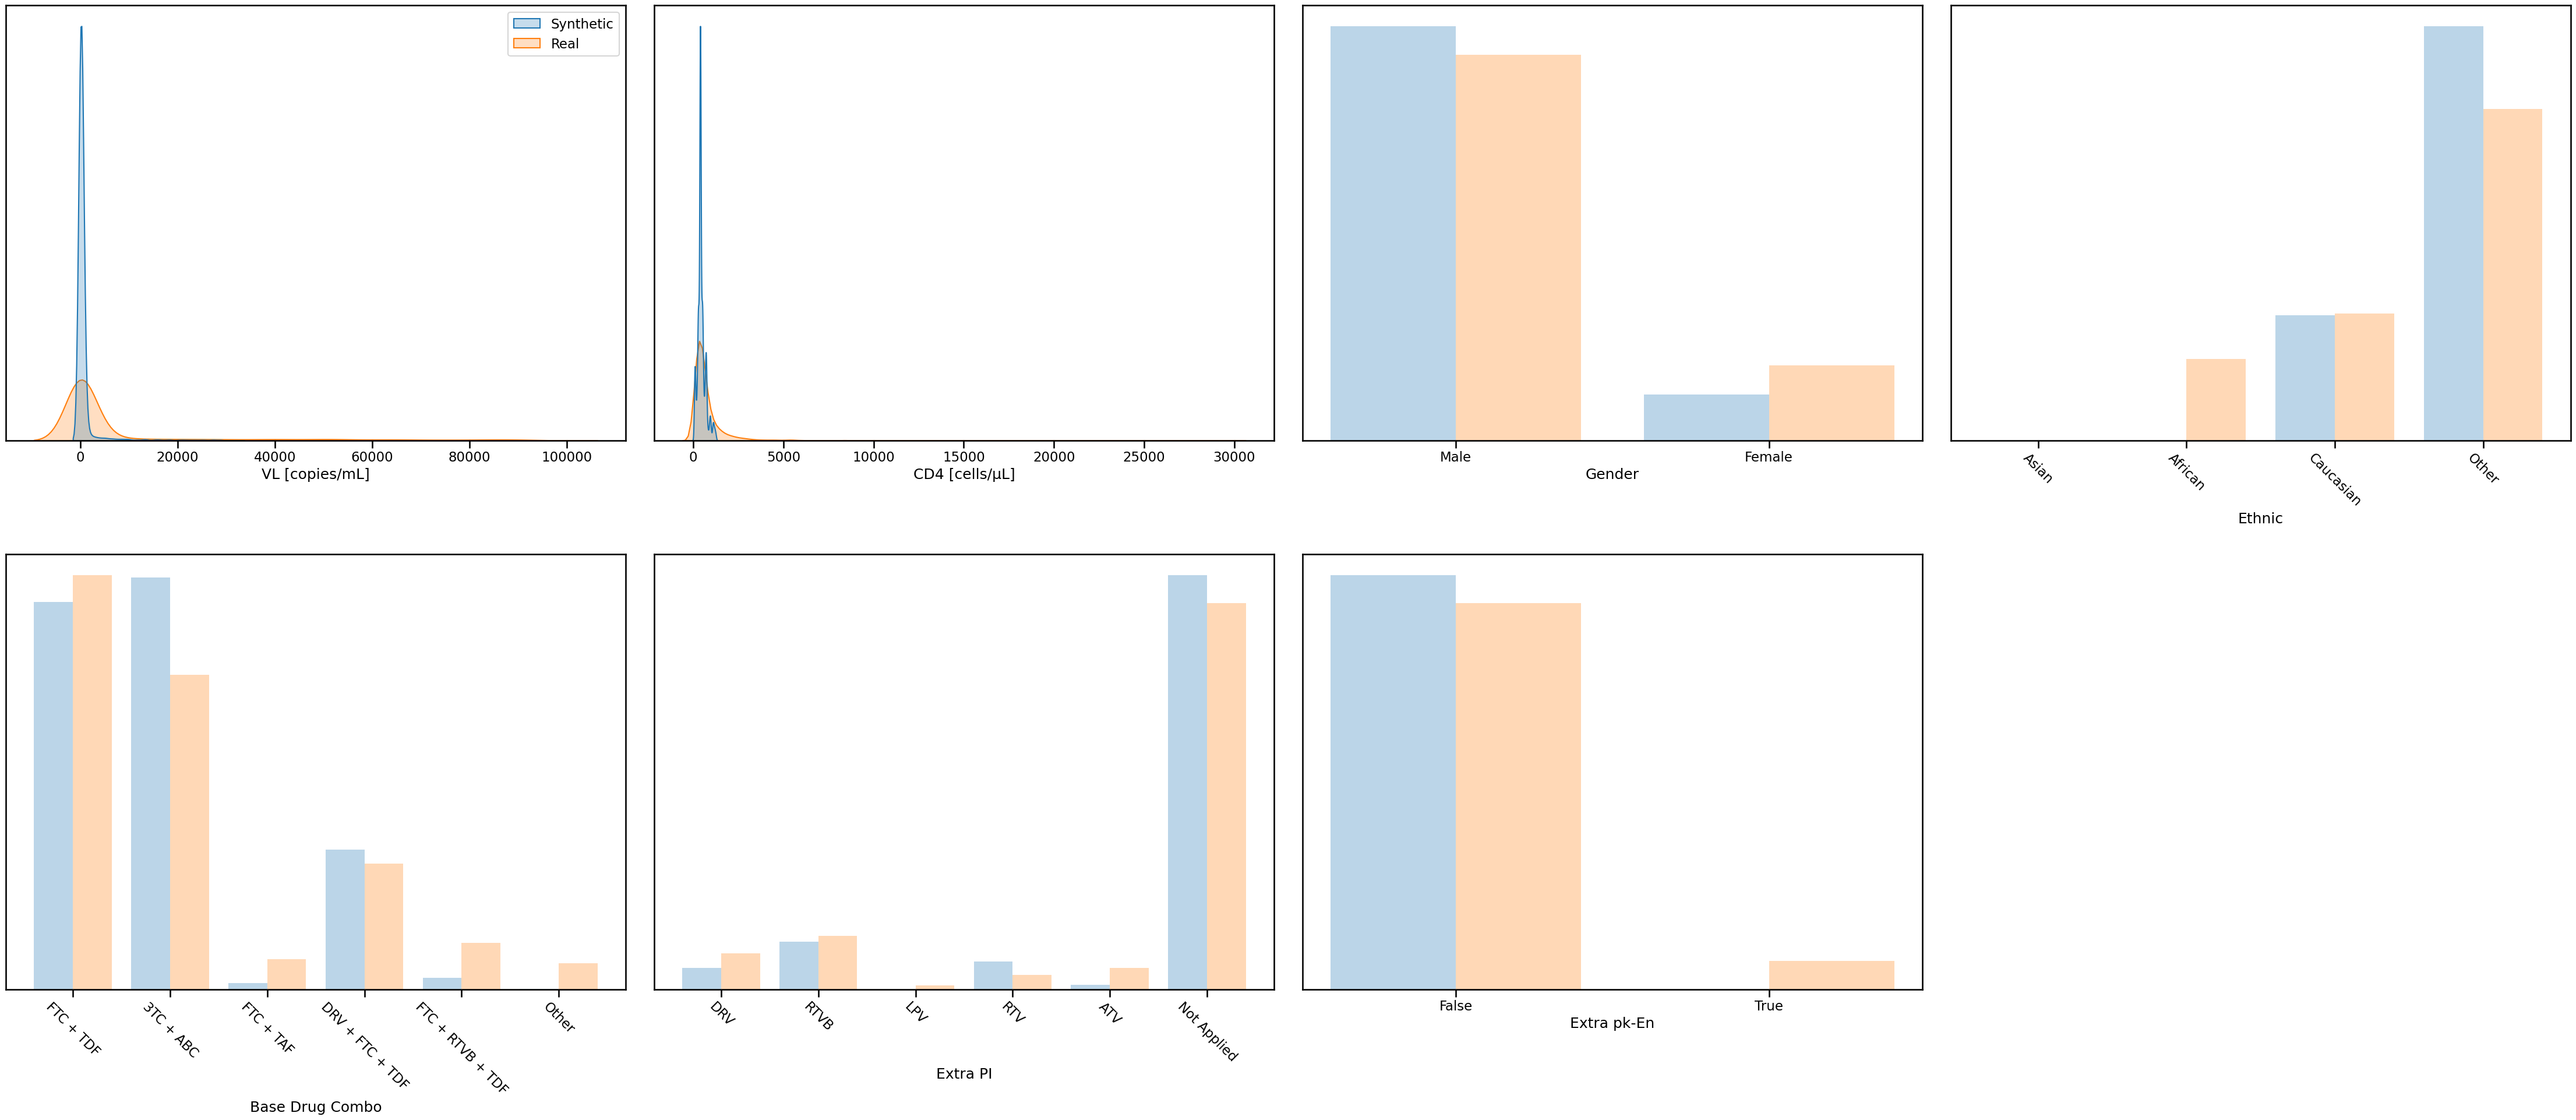

In [ ]:
seed_all()

loader60 = only10_60[60]
Real_Seqs = collect_loader_sequences(loader60)
Fx = int(max(dtype["index_end"]))
Generated_Len = 60

Real_Data = sample_and_flatten(Real_Seqs, seq_len=Generated_Len, max_rows=10_000)
Fake_Data = wgan_gp.generate_data(Generated_Len, num_samples=Real_Seqs.size(0))
Fake_Data = Fake_Data[: Real_Data.size(0) // Generated_Len].reshape(-1, Fx)

with torch.no_grad():
    Real_Data = Execute_C007(Real_Data, dtype_schema=dtype, transform_params=art_transformation_params)
    Fake_Data = Execute_C007(Fake_Data, dtype_schema=dtype, transform_params=art_transformation_params)

Real_Data = to_cpu(Real_Data)
Fake_Data = to_cpu(Fake_Data)

Replace_Names, _ = Execute_C008(dtype)
n_features = len(Replace_Names)
ncols = 4
nrows = (n_features + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(45, 10 * nrows))
axes = np.atleast_2d(axes)

for k, name in enumerate(Replace_Names):
    i, j = divmod(k, ncols)
    cur_ax = axes[i, j]
    cur_fake = Fake_Data[:, k].numpy()
    cur_real = Real_Data[:, k].numpy()

    if name in REAL_NAMES:
        df_all = make_df(name, cur_real, cur_fake, categorical=False)
        sns.kdeplot(data=df_all, x=name, hue="Type", fill=True, ax=cur_ax, legend=(k == 0), common_norm=False)
        if cur_ax.legend_:
            cur_ax.legend_.set_title(None)
        cur_ax.yaxis.set_visible(False)
        cur_ax.set(xlabel=name)
    else:
        df_all = make_df(name, cur_real, cur_fake, categorical=True)
        sns.histplot(
            data=df_all, x=name, hue="Type", multiple="dodge", stat="probability",
            shrink=0.8, alpha=0.3, linewidth=0, ax=cur_ax, legend=False, discrete=True
        )
        cur_ax.tick_params(axis="x", rotation=-45 if name in CATEGORY_LABELS and len(CATEGORY_LABELS[name]) > 3 else 0)
        cur_ax.yaxis.set_visible(False)
        cur_ax.set(xlabel=name)

for k in range(n_features, nrows * ncols):
    i, j = divmod(k, ncols)
    axes[i, j].axis("off")

plt.tight_layout(pad=1.0)
plt.show()

In [ ]:
torch.save(wgan_gp.G.state_dict(), 'ZY002_G_StateDict_Epoch100')
torch.save(wgan_gp.D.state_dict(), 'ZY002_D_StateDict_Epoch100')
torch.save(wgan_gp.A.state_dict(), 'ZY002_A_StateDict_Epoch100')

torch.save(wgan_gp.A.Mean_Container, "ZY002_Mean_Container_Epoch100")

In [ ]:
seed_all()

# Experimental setup
Hyper002_Epochs    = 200

#---
# Continue to train a pre-trained variant
Hyper010_Continue  = True
Hyper011_G_SD      = "ZY002_G_StateDict_Epoch100"
Hyper012_D_SD      = "ZY002_D_StateDict_Epoch100"
Hyper0012_A_SD     = 'ZY002_A_StateDict_Epoch100'
Hyper0012_A_MC     = 'ZY002_Mean_Container_Epoch100'
Hyper013_PreEpoch  = 100


In [ ]:
wgan_gp = Execute_D004(
                Hyper001_BatchSize, Hyper002_Epochs,
                Hyper003_G_iter, Hyper004_GP_Lambda, Hyper005_C_Lambda,
                Hyper006_ID, Hyper007_HD,
                Hyper008_LR, Hyper009_Betas,
                dtype,
                correlation_real,
                [Hyper010_Continue,
                 Hyper011_G_SD, Hyper012_D_SD,
                 [Hyper0012_A_SD, Hyper0012_A_MC],
                 Hyper013_PreEpoch])


In [ ]:
wgan_gp.train(only10_60)

/tmp/ipython-input-1314674709.py:166: RuntimeWarning: divide by zero encountered in remainder
  if (np.mod(batch_idx + 1, round(len(Cur_loader) / 5)) == 0) or \


#---
[Epoch 101] L=10 step 1/1 | D_loss=-2.2322 GP=0.2236 D_real=8.0362 D_fake=5.5804 | G_loss=-4.5163 Corr=0.0924
A_Loss: 	0.4106619358062744
#---
[Epoch 101] L=20 step 1/1 | D_loss=-2.8344 GP=0.3437 D_real=9.8547 D_fake=6.6766 | G_loss=-5.9870 Corr=0.0852
A_Loss: 	1.3364253044128418
#---
[Epoch 101] L=30 step 1/1 | D_loss=-2.9669 GP=1.0383 D_real=11.4567 D_fake=7.4515 | G_loss=-6.2048 Corr=0.0862
A_Loss: 	0.7376559376716614
#---
[Epoch 101] L=40 step 1/1 | D_loss=-3.9066 GP=0.6157 D_real=12.7401 D_fake=8.2178 | G_loss=-7.4342 Corr=0.0767
A_Loss: 	0.24223017692565918
#---
[Epoch 101] L=50 step 1/1 | D_loss=-4.0595 GP=1.1258 D_real=14.6034 D_fake=9.4180 | G_loss=-7.7004 Corr=0.0866
A_Loss: 	1.0357929468154907
#---
[Epoch 101] L=60 step 1/1 | D_loss=-5.5049 GP=1.5051 D_real=15.2785 D_fake=8.2684 | G_loss=-7.5358 Corr=0.0842
A_Loss: 	0.6293120384216309
#---
[Epoch 102] L=10 step 1/1 | D_loss=-1.2330 GP=0.3236 D_real=8.1138 D_fake=6.5572 | G_loss=-5.5118 Corr=0.0904
A_Loss: 	0.45016339421

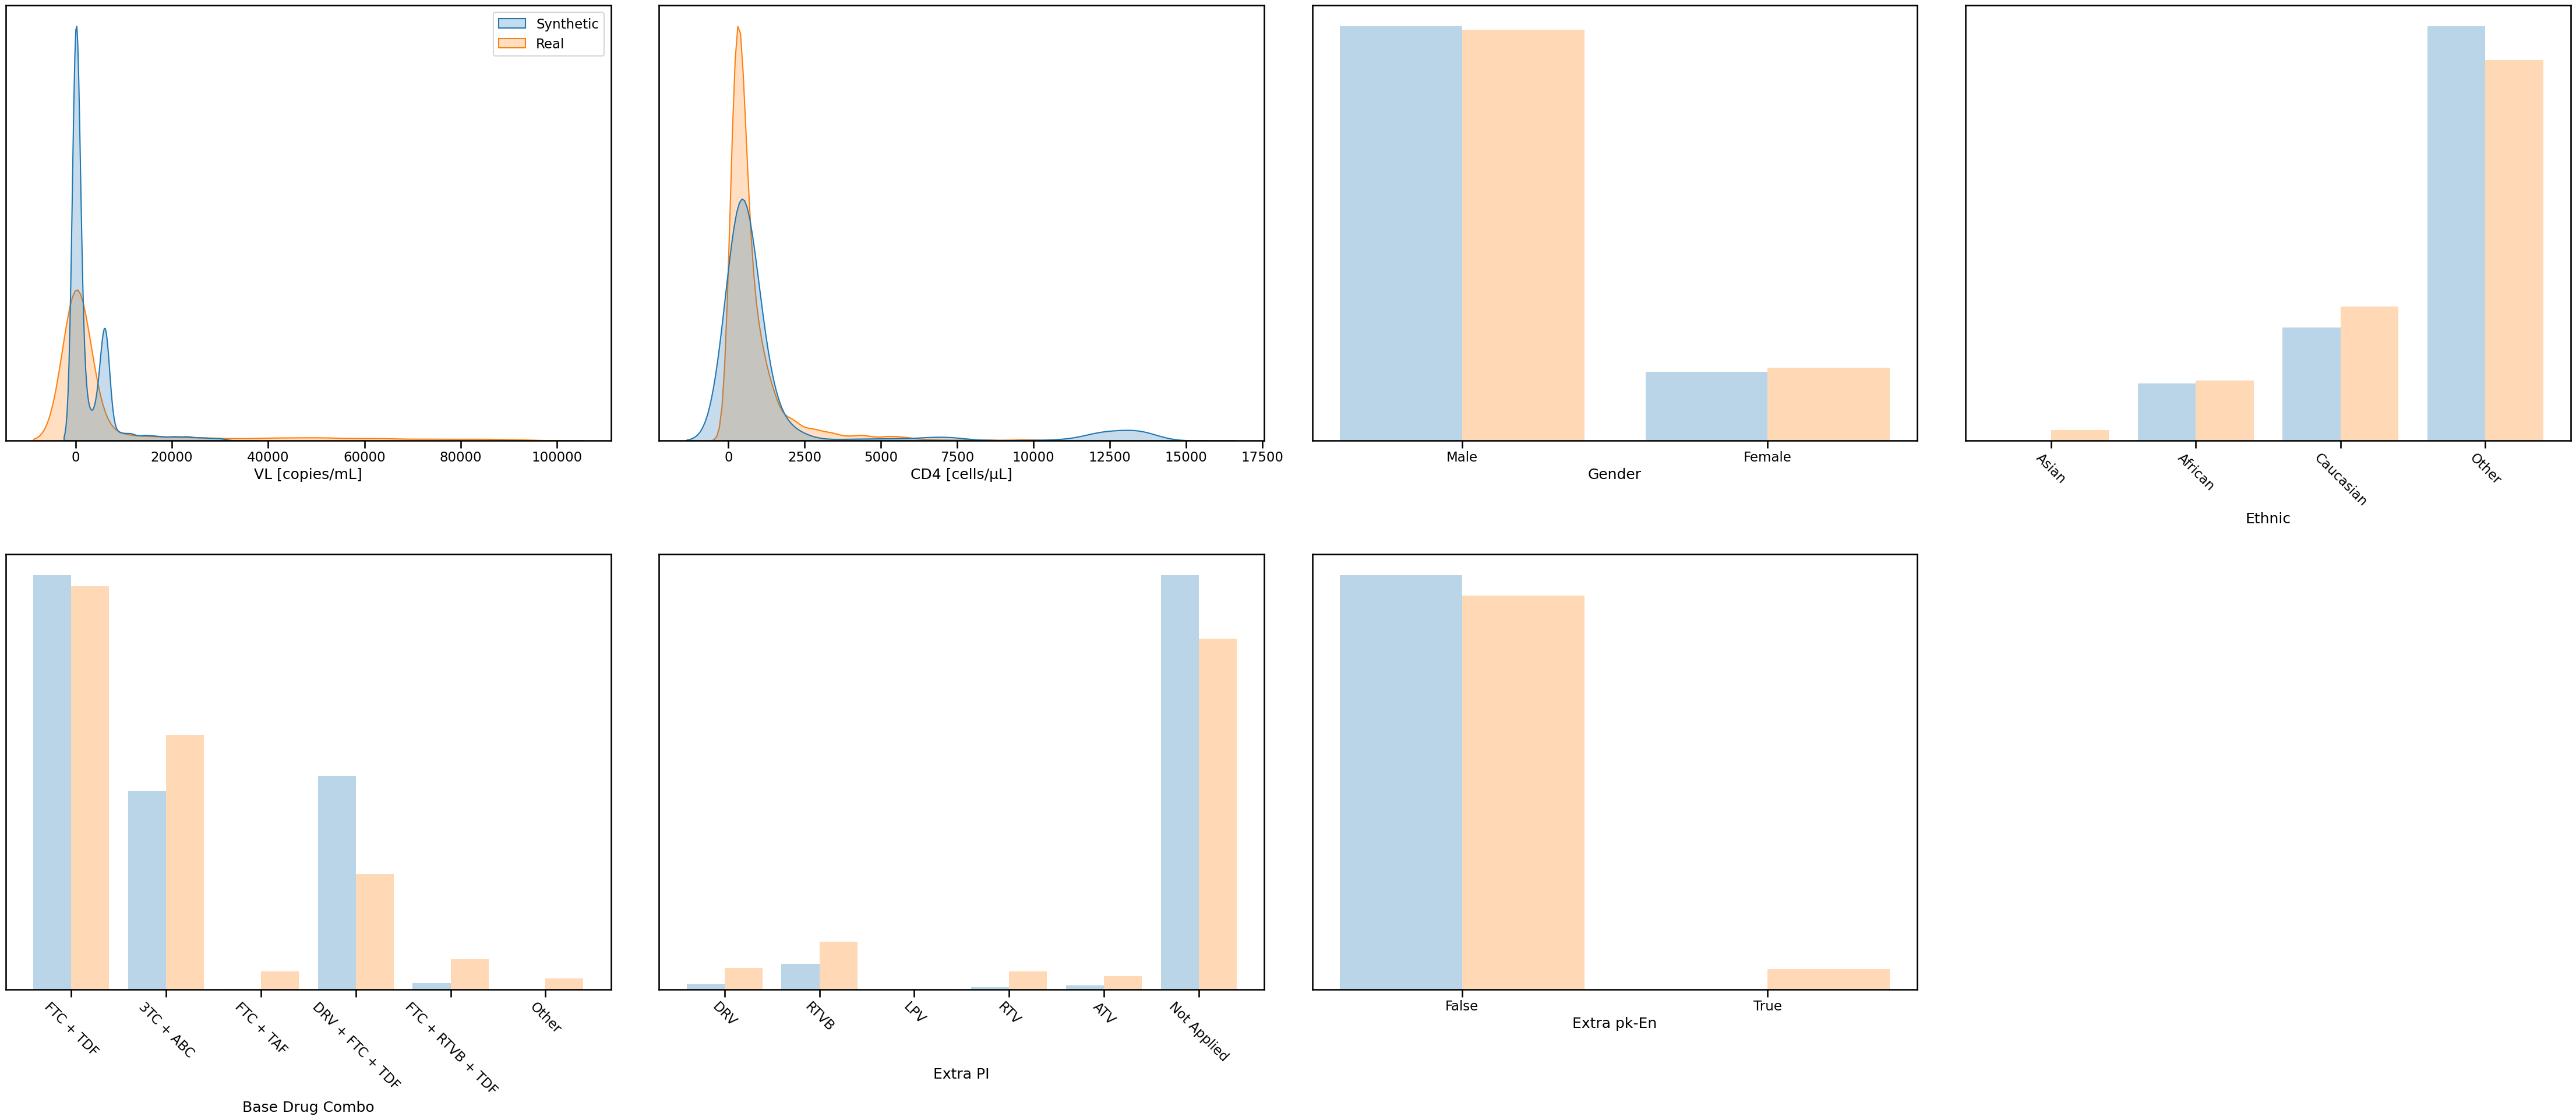

In [ ]:
seed_all()

loader60 = only10_60[60]
Real_Seqs = collect_loader_sequences(loader60)
FX = int(max(dtype["index_end"]))
Generated_Len = 60

Real_Data = sample_and_flatten(Real_Seqs, seq_len=Generated_Len, max_rows=10_000)
Fake_Data = wgan_gp.generate_data(Generated_Len, num_samples=Real_Seqs.size(0))
Fake_Data = Fake_Data[: Real_Data.size(0) // Generated_Len].reshape(-1, FX)

with torch.no_grad():
    Real_Data = Execute_C007(Real_Data, dtype_schema=dtype, transform_params=art_transformation_params)
    Fake_Data = Execute_C007(Fake_Data, dtype_schema=dtype, transform_params=art_transformation_params)

Real_Data = to_cpu(Real_Data)
Fake_Data = to_cpu(Fake_Data)

Replace_Names, _ = Execute_C008(dtype)
n_features = len(Replace_Names)
ncols = 4
nrows = (n_features + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(45, 10 * nrows))
axes = np.atleast_2d(axes)

for k, name in enumerate(Replace_Names):
    i, j = divmod(k, ncols)
    cur_ax = axes[i, j]
    cur_fake = Fake_Data[:, k].numpy()
    cur_real = Real_Data[:, k].numpy()

    if name in REAL_NAMES:
        df_all = make_df(name, cur_real, cur_fake, categorical=False)
        sns.kdeplot(data=df_all, x=name, hue="Type", fill=True, ax=cur_ax, legend=(k == 0), common_norm=False)
        if cur_ax.legend_:
            cur_ax.legend_.set_title(None)
        cur_ax.yaxis.set_visible(False)
        cur_ax.set(xlabel=name)
    else:
        df_all = make_df(name, cur_real, cur_fake, categorical=True)
        sns.histplot(
            data=df_all, x=name, hue="Type", multiple="dodge", stat="probability",
            shrink=0.8, alpha=0.3, linewidth=0, ax=cur_ax, legend=False, discrete=True
        )
        cur_ax.tick_params(axis="x", rotation=-45 if name in CATEGORY_LABELS and len(CATEGORY_LABELS[name]) > 3 else 0)
        cur_ax.yaxis.set_visible(False)
        cur_ax.set(xlabel=name)

for k in range(n_features, nrows * ncols):
    i, j = divmod(k, ncols)
    axes[i, j].axis("off")

plt.tight_layout(pad=1.0)
plt.show()

In [ ]:
torch.save(wgan_gp.G.state_dict(), 'ZY002_G_StateDict_Epoch200')
torch.save(wgan_gp.D.state_dict(), 'ZY002_D_StateDict_Epoch200')
torch.save(wgan_gp.A.state_dict(), 'ZY002_A_StateDict_Epoch200')

torch.save(wgan_gp.A.Mean_Container, "ZY002_Mean_Container_Epoch200")